In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [66]:
df = pd.read_csv("dataset.csv", index_col = 0, delimiter = ',')

In [67]:

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['P_all_power'].values.reshape(-1,1))

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size-60:, :]


X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [68]:
encoding_dim = 32

input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))

encoded = Dense(encoding_dim, activation='relu')(input_layer)

decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0521 - val_loss: 0.0233
Epoch 2/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0055
Epoch 3/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 4/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 5/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 6/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 7/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 8/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 9/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 10/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0025 - val_lo

In [69]:
#X_train.reshape(-1,1,1),X_train[:,:,0].shape

In [70]:

predicted = autoencoder.predict(X_train)

mse = np.mean(np.power(X_train[:,:,0] - predicted, 2), axis=1)

threshold = np.quantile(mse, 0.99)

anomalies = mse > threshold


257/257 [==============================] - 0s 1ms/step


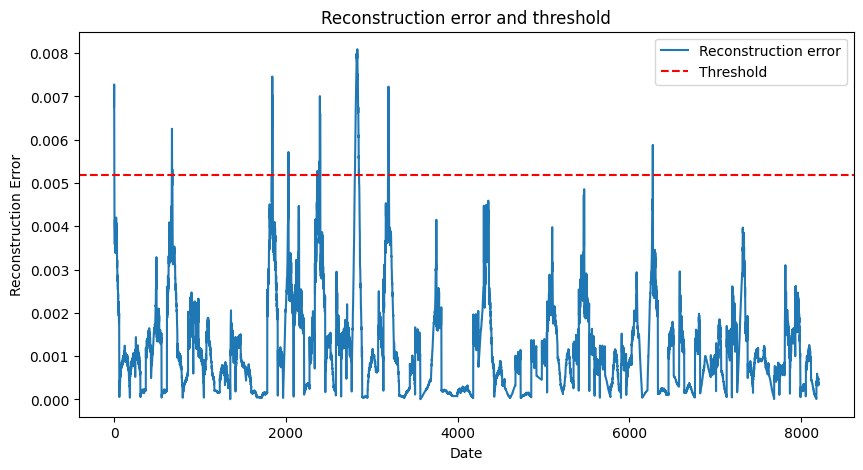

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(mse, label='Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction error and threshold')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.legend(loc='best')
plt.show()


In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [73]:
max_float32 = np.finfo(np.float).max
train = np.where(np.isinf(df), max_float32, df)
# Заполнение пропущенных значений
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

# Стандартизация данных
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns = df.columns)
dbscan = DBSCAN(eps=0.3, min_samples=5)
predictions = dbscan.fit_predict(df_scaled)

outlier_index = np.where(predictions == -1)
outliers = df_scaled.iloc[outlier_index]



/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_36021/2227946692.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_float32 = np.finfo(np.float).max


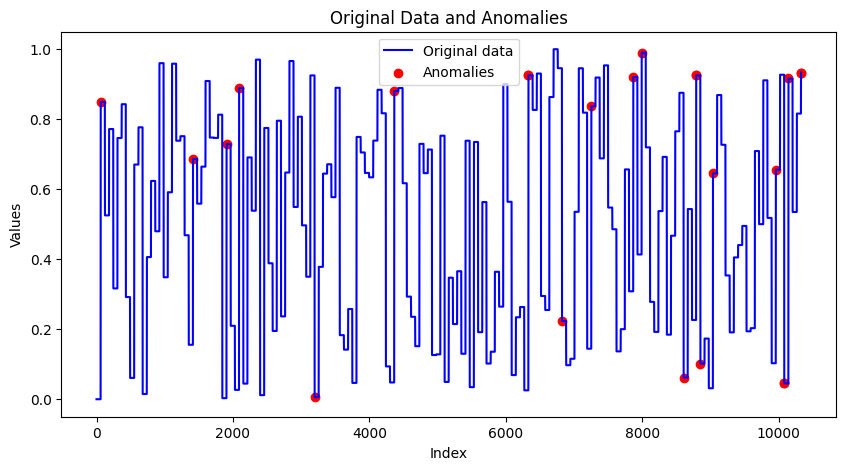

In [74]:
plt.figure(figsize=(10,5))
plt.plot(df_scaled.index, df_scaled.iloc[:, 0], color='blue', label='Original data')
plt.scatter(outliers.index, outliers.iloc[:, 0], color='red', label='Anomalies')

plt.title('Original Data and Anomalies')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend(loc='best')
plt.show()

In [75]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df))

threshold = 1

outliers = np.where(z > threshold)

print(df.iloc[outliers])


             P_vent  P_technique  P_room_heating     P_pump  P_lightnig  \
time                                                                      
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
...             ...          ...             ...        ...         ...   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   

            P_heating  P

In [76]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

df_feature = df['P_all_power']

z = np.abs(stats.zscore(df_feature))

threshold = 1

outlier_indices = np.where(z > threshold)

outliers = df_feature.iloc[outlier_indices]

print("Outlier indices: ", outlier_indices)
print("Outliers: ", outliers.values)



Outlier indices:  (array([    0,     1,     2, ..., 10325, 10326, 10327]),)
Outliers:  [   0.            0.            0.         ... 2168.48122159 2168.48122159
 2168.48122159]


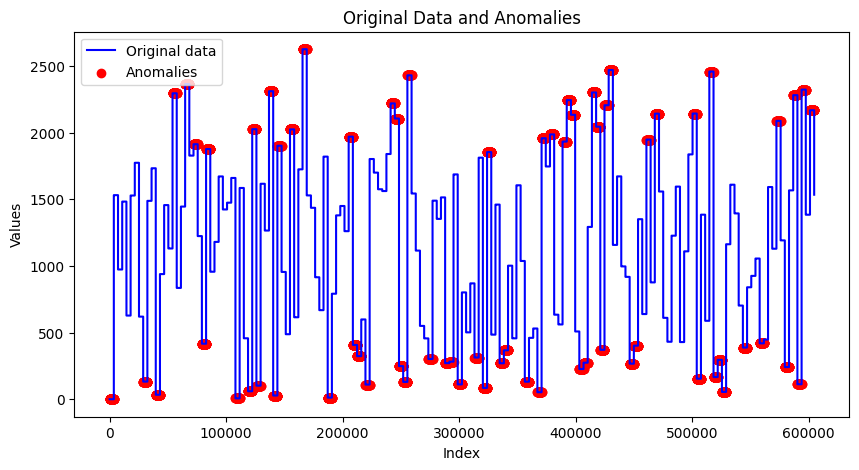

In [77]:
plt.figure(figsize=(10,5))
plt.plot(df_feature.index, df_feature.values, color='blue', label='Original data')
plt.scatter(outliers.index, outliers.values, color='red', label='Anomalies')

plt.title('Original Data and Anomalies')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend(loc='best')
plt.show()